# EV Charging Behavior

## Overview
This is an initial capstone project to fullfil the requirements of the UC Berkely's Professional Certificate in Machine Learnig And Artificial Intelligence. The problem statement of this project is:"Can we predict whether an EV charging session represents a Casual Driver, Commuter, or Long-Distance Traveler based on charging and driving behaviors, and how can these insights support better charging infrastructure planning and personalized EV services?"


## 1. Data Understanding
The dataset used in this project is [Global_EV_Charging_Behavior_2024](https://www.kaggle.com/datasets/atharvasoundankar/global-ev-charging-behavior-2024) downloaded from Kaggle.  It contains 800 rows and 18 Columns, providing a comprehesive and realistic view of EV charging usage and trends across different regions worldwide.

The Dataset was chosen to replace the previoius proposed dataset[electric-vehicle-charging-patterns](https://www.kaggle.com/datasets/valakhorasani/electric-vehicle-charging-patterns). After a deeper analysis, the earlier dataset was found to be less realistic, making Global_EV_Charging_Behavior2024 a more suitable choice for the capstone project.

### Key Characteristics of the Dataset  
- **Size:** ~800 sessions × 16 attributes  
- **Coverage:** Global scope, reflecting diverse EV usage and charging environments  
- **Granularity:** Session-level data (each row corresponds to one charging session)  

### Important Columns Used  
- **Charging Start Time** – exact start timestamp, used to derive *Time of Day* and *Day Type (Weekday/Weekend)*.  
- **Battery Capacity (kWh)** – vehicle’s full battery size, a baseline for calculating State of Charge (SOC) changes.  
- **Energy Delivered (kWh)** – amount of energy provided in the session; used for labeling user type but excluded as a model feature to avoid leakage.  
- **Charging Cost ($)** – session cost, strongly influenced by vendor packages and incentives; retained as a key predictor of behavior.  
- **Payment Method** – categorical variable (Subscription, Card, App) that acts as a proxy for billing structure and package plans.  
- **Charging Station Type** – Level 1 / Level 2 / DC Fast; reflects charging speed and user patience.  
- **Charging Session Outcome** – whether a session was completed, failed, or aborted; noted but excluded since the effect is already reflected in energy delivered.  

### Label Creation (User Type)  
The dataset does not directly include user labels. To classify sessions, we derived **UserType** based on the percentage change in battery SOC during a charging session:  
- `< 20%` → **Casual Driver**  
- `20–60%` → **Commuter**  
- `> 60%` → **Long-Distance Traveler**  

### Observations from Early Analysis  
- **Cost is not proportional to kWh delivered**, due to discounts, subscriptions, and free-charging incentives. This makes cost a proxy for **package plan influence** rather than a direct measure of consumption.  
- **Payment Method** further reflects these incentives, as Subscription users behave differently from Card payers.  



## 2. Read in the Data

In [28]:
# Import
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

IMAGES_DIR, FINDINGS_DIR = 'images', 'findings'
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(FINDINGS_DIR, exist_ok=True)

df = pd.read_csv('data/Global_EV_Charging_Behavior_2024.csv')
print(df.shape)
df.head()

(800, 16)


,Country,City,Charging Station ID,Charging Station Type,EV Model,Manufacturer,Battery Capacity (kWh),Charging Start Time,Charging End Time,Charging Duration (mins),Energy Delivered (kWh),Charging Cost ($),Payment Method,Temperature (°C),Charging Session Outcome,Station Utilization Rate (%)
0,Germany,Berlin,CS-8195,DC Fast,Hyundai Kona Electric,Hyundai,64,2025-03-31 18:13:40,2025-03-31 19:30:40,77,18.17,5.83,Subscription,30.7,Completed,57.2
1,USA,New York,CS-5103,DC Fast,Nissan Leaf,Nissan,40,2025-03-08 13:17:05,2025-03-08 14:27:05,70,13.14,3.69,Card,23.6,Failed,53.6
2,France,Lyon,CS-4527,Level 1,BYD Han,BYD,76,2025-01-21 20:08:51,2025-01-21 21:34:51,86,62.47,6.37,Subscription,11.9,Aborted,22.4
3,India,Mumbai,CS-5717,DC Fast,Nissan Leaf,Nissan,40,2025-04-04 21:11:29,2025-04-04 23:03:29,112,8.39,2.97,App,27.3,Failed,46.8
4,Germany,Munich,CS-5093,Level 2,Nissan Leaf,Nissan,40,2025-03-27 14:58:49,2025-03-27 17:34:49,156,15.26,4.40,Subscription,2.7,Completed,13.7


## 3. Features Understanding

### Features Used in Modeling  

**Numeric Features**  
- **Charging Cost ($)** – total session cost; strongest predictor because it reflects vendor package influence (free charging, discounts, or subscription plans).  
- **Battery Capacity (kWh)** – vehicle’s total battery size; indicates driving range and how much energy a full charge requires.
- **Cost_per_kWh** – effective price per unit of energy; helps normalize charging cost differences across packages, stations, and regions.

**Categorical Features**  
- **Charging Station Type** – {Level 1, Level 2, DC Fast}; captures charging speed and driver patience.  
- **TimeOfDay** – {Morning, Office Hours, Evening, Night, Deep Night}; behavioral pattern for when users charge.  
- **DayType** – {Weekday, Weekend}; separates work-related charging (commuters) from leisure/weekend trips.  
- **Payment Method** – {Subscription, Card, App}; acts as a proxy for vendor incentives and billing plans.  

---

### Features Excluded from Modeling  

- **Energy Delivered (kWh)** – used to create the target label (UserType); excluded to avoid data leakage.  
- **SOC_Change_Pct** – derived from energy and capacity; only used for labeling, not as a predictor.  
- **Duration (mins)** – highly correlated with energy delivered and station type; redundant.    
- **Charging Session Outcome** – completion/abort status already reflected in energy delivered.  

### Other Features Excluded from Modeling
    Country, City, Charging Station ID, EV Model, Manufacturer, Charging Start Time, Chargin End Time, Temperature, Charging Session Outcome, Station Utilization Rate.

In [29]:
print("The data information of the dataset: ")
df.info()

The data information of the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       800 non-null    object 
 1   City                          800 non-null    object 
 2   Charging Station ID           800 non-null    object 
 3   Charging Station Type         800 non-null    object 
 4   EV Model                      800 non-null    object 
 5   Manufacturer                  800 non-null    object 
 6   Battery Capacity (kWh)        800 non-null    int64  
 7   Charging Start Time           800 non-null    object 
 8   Charging End Time             800 non-null    object 
 9   Charging Duration (mins)      800 non-null    int64  
 10  Energy Delivered (kWh)        800 non-null    float64
 11  Charging Cost ($)             800 non-null    float64
 12  Payment Method            

### Missing value checked: There are no missing value

In [30]:
# NaN missingness by column
na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_df = pd.DataFrame({"NaN_count": na_counts, "NaN_pct": na_pct})
print("\n=== NaN Missingness ===")
display(missing_df.head(18))


=== NaN Missingness ===


,NaN_count,NaN_pct
Country,0,0.0
City,0,0.0
Charging Station ID,0,0.0
Charging Station Type,0,0.0
EV Model,0,0.0
Manufacturer,0,0.0
Battery Capacity (kWh),0,0.0
Charging Start Time,0,0.0
Charging End Time,0,0.0
Charging Duration (mins),0,0.0


### Correlationship between Cost and Energy Delivered by Charging Station Type
-  There’s a general upward trend means correlationship is OK (more kWh → higher cost).
-  But the spread is wide (means variance is large): two sessions with the same energy delivered may have very different costs.
-  This proves that pricing plans/packages distort the cost relationship.

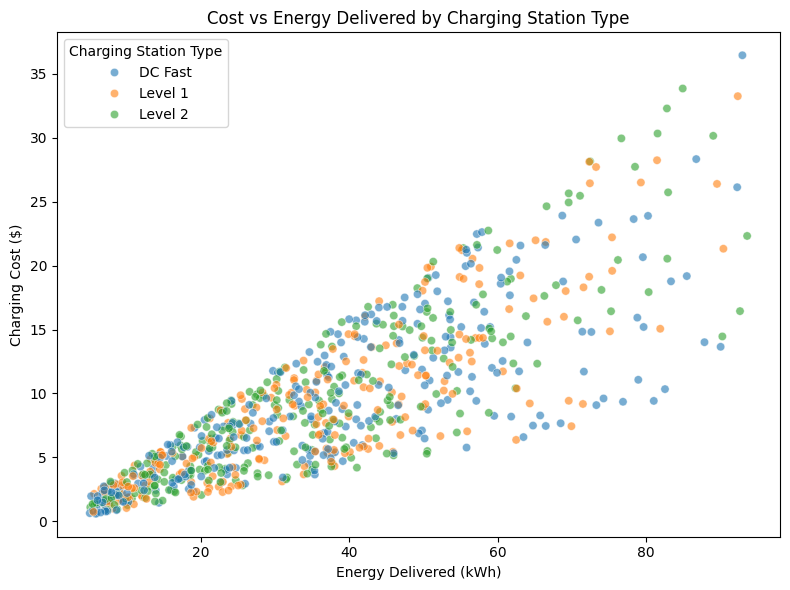

In [31]:
# Scatterplot: Cost vs Energy Delivered, grouped by Charging Station Type
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='Energy Delivered (kWh)',
    y='Charging Cost ($)',
    hue='Charging Station Type',
    alpha=0.6
)
plt.title('Cost vs Energy Delivered by Charging Station Type')
plt.tight_layout()
plt.show()



## 3. Engineering Features
Engineering new column:   
TimeOfDay:Morning, Office Hours, Evening, Night, Deep Night
DayType: Weekday, Weekend  
Cost_per_kWh: cost/enery delivered  
SOC_Change_Pct: Energy delivered/capacity of battery

In [32]:
dt_col = 'Charging Start Time'
cap_col = 'Battery Capacity (kWh)'
energy_col = 'Energy Delivered (kWh)'
dur_col = 'Charging Duration (mins)'
cost_col = 'Charging Cost ($)'
ctype_col = 'Charging Station Type'

# Sanity checks
for c in [dt_col, cap_col, energy_col, dur_col, cost_col, ctype_col]:
    assert c in df.columns, f"Missing column: {c}"

# Parse time
df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')

def time_of_day(h):
    if pd.isna(h): return np.nan
    if 6 <= h < 9:   return 'Morning'
    if 9 <= h < 17:  return 'Office Hours'
    if 17 <= h < 22: return 'Evening'
    if 22 <= h < 24: return 'Night'
    return 'Deep Night'

df['TimeOfDay'] = df[dt_col].dt.hour.apply(time_of_day)
df['DayType'] = df[dt_col].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Economic feature
df['Cost_per_kWh'] = np.where(df[energy_col] > 0, df[cost_col] / df[energy_col], np.nan)

# SOC% change (for labeling only)
df['SOC_Change_Pct'] = (df[energy_col] / df[cap_col]) * 100

def label_user(soc):
    if pd.isna(soc): return np.nan
    if soc < 20: return 'Casual'
    if soc < 60: return 'Commuter'
    return 'Long-Distance'

df['UserType'] = df['SOC_Change_Pct'].apply(label_user)

# Drop unwanted columns if present
for col_to_drop in ['Charging Duration (mins)', 'Duration_hours', 'ChargeRate_kW']:
    if col_to_drop in df.columns:
        df = df.drop(columns=[col_to_drop])

print('Columns now:', df.columns.tolist())
print('Class counts:\n', df['UserType'].value_counts())

Columns now: ['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)', 'TimeOfDay', 'DayType', 'Cost_per_kWh', 'SOC_Change_Pct', 'UserType']
Class counts:
 UserType
Long-Distance    359
Commuter         330
Casual           111
Name: count, dtype: int64


### Box Plot for cost by User Type  
- Casual users: consistently low costs
- Commuters: moderate costs with tighter spread.
- Long-Distance travelers: higher costs, but also very wide spread
  (maybe the effect of free/discounted plans.)

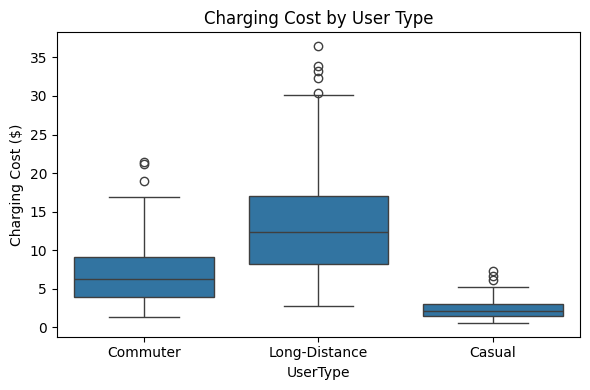

In [33]:
# Boxplot by UserType (optional)
if 'UserType' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='UserType', y='Charging Cost ($)')
    plt.title('Charging Cost by User Type')
    plt.tight_layout()
    plt.show()

## 4. Modeling

In [47]:
feature_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)','Cost_per_kWh',
                'Charging Station Type', 'TimeOfDay', 'DayType','Payment Method']
target_col = 'UserType'

X = df[feature_cols].copy()
y = df[target_col].copy()

numeric_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)', 'Cost_per_kWh']
#numeric_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)']
categorical_cols = ['Charging Station Type', 'TimeOfDay', 'DayType','Payment Method']


num_tf = Pipeline([('imputer', SimpleImputer(strategy='median')),
                   ('scaler', StandardScaler())])
cat_tf = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([('num', num_tf, numeric_cols),
                                ('cat', cat_tf, categorical_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (640, 7)  Test: (160, 7)


### Train Default Logistic Regression + Quick Metrics
The result show:  
Accuracy = 0.850 | Macro-F1 = 0.812  
Accuracy is solid.  
Macro-F1 shows some imbalance (Casual users are weaker).  

In [54]:
clf = Pipeline([('preprocessor', preprocess),
                ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

# Quick summary
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Quick Summary -> Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")

               precision    recall  f1-score   support

       Casual       0.87      0.59      0.70        22
     Commuter       0.82      0.82      0.82        66
Long-Distance       0.87      0.96      0.91        72

     accuracy                           0.85       160
    macro avg       0.85      0.79      0.81       160
 weighted avg       0.85      0.85      0.85       160

Quick Summary -> Accuracy: 0.850 | Macro-F1: 0.812


## Evaluation


### Confusion Matrix
**Result of the Confusion Matrix:**   
Accuracy for the Casual Driver = 14/22=64%  
Accuracy for the Commuters = 54/66=82%  
Accuracy for the Long Distance ravelers = 69/72=96%  
The model is very strong for Long-Distance (96%) and Commuters (82%).
It struggles more with Casual Drivers (64%), often confusing them with Commuters.

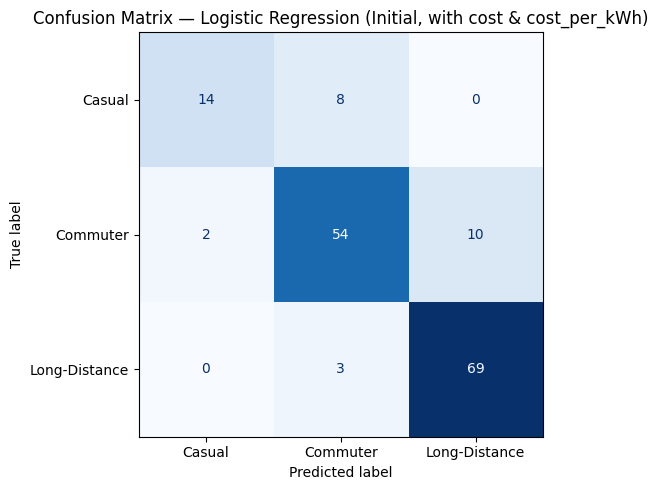

In [49]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)

plt.figure(figsize=(6,5))
disp.plot(values_format='d', cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title('Confusion Matrix — Logistic Regression (Initial, with cost & cost_per_kWh)')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'initial_confusion_logreg_costs.png'), dpi=150)
plt.show()

### ROC Curves (One-vs-Rest)
ROC AUC values for each class are high
Casual = 0.99   
Commuter = 0.94   
Long-Distance = 0.986  
It show strong separation on the classes

Macro AUC (OvR): 0.972


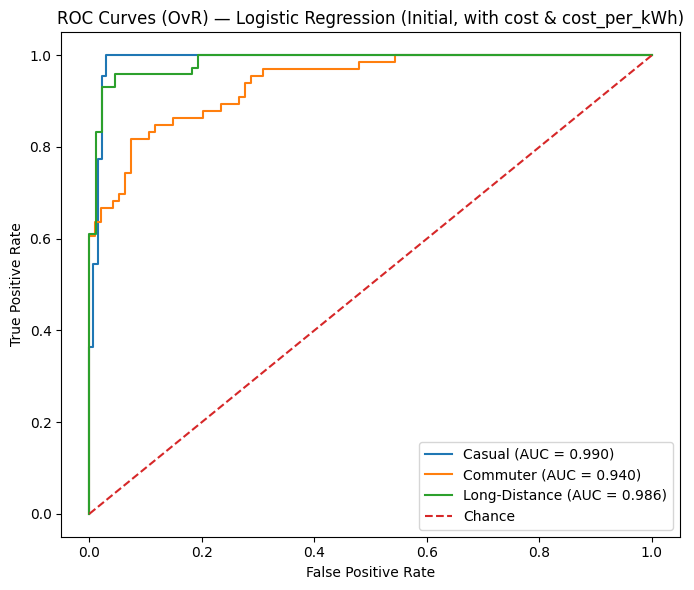

In [50]:
y_proba = clf.predict_proba(X_test)
classes = clf.classes_
y_test_bin = pd.get_dummies(y_test).reindex(columns=classes, fill_value=0).values

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = np.mean(list(roc_auc.values()))
print(f'Macro AUC (OvR): {macro_auc:.3f}')

plt.figure(figsize=(7,6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')
plt.plot([0,1],[0,1],'--',label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (OvR) — Logistic Regression (Initial, with cost & cost_per_kWh)')
plt.legend(loc='lower right'); plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'initial_roc_logreg_costs.png'), dpi=150)
plt.show()